<table>
<tr>
    <td width=25%>
        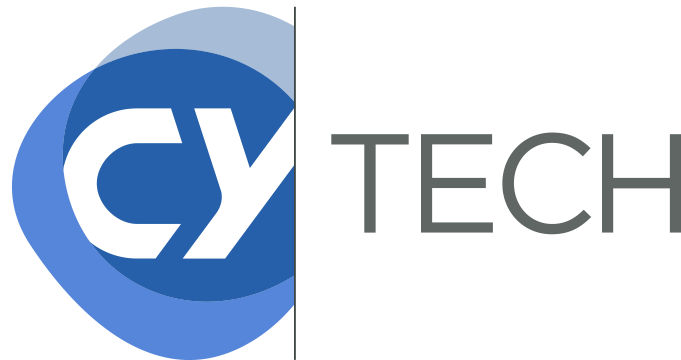
    </td>
    <td>
        <center>
            <h1>Deep Learning et Applications</h1>
        </center>
    </td>
    <td width=15%>
        Paul Gay
    </td>
</tr>
</table>

<br/>
<div id="top"></div>
<center>
    <a style="font-size: 20pt; font-weight: bold">Premier pas avec Ollama et système RAG</a>
</center>
<br/>

---

À cause de leur popularité, la construction d'outils pour utiliser les llms est un domaine très actif ! Ce TP vous propose d'utiliser l'un d'eux : [Ollama](https://www.ollama.com/)


La deuxième partie consiste à construire un chatbot soutenu par un système Retrieval Augmentation Generation (RAG), c'est de loin l'une des applications les plus populaires des llms, et actuellement (2024) la plupart des entreprises sont en train de les déployer en interne.

L'exemple proposé ici est de construire un chatbot qui répondra à vos questions sur votre cours de Deep Learning, (ou tout autre cours que vous souhaiteriez tester). 

En pratique, un grand modèle permet d'obtenir une meilleure génération, dans le cadre de ce cours, nous utiliserons un modèle plus petit (par ex: gemma:2B, 2 milliards de paramètres). Cependant, ces modèles de taille intermédiaire ont déjà de bonne capacités de générations et peuvent être utilisées en pratique. De plus, ils réduisent la dépendance à des serveurs puissants, qui ne sont pas toujours accessibles en fonction des projets.


Ce TP nous permettra de voir la facilité de construire un prototype avec un llm, en fait, peu de connaissances théoriques du machine learning sont nécessaires. En revanche, le choix du modèle, son évaluation, et le type d'infrastructure GPU nécessaire pour obtenir des résultats acceptables demande une bonne culture, et de suivre l'actualité très dynamique des llms. 

--- 



## Premiers pas avec ollama

Installation 

```
curl -fsSL https://ollama.com/install.sh | sh
```

Installation de l'api python

```
pip install ollama
```

In [2]:
import ollama
from ollama import chat
from ollama import ChatResponse
from bs4 import BeautifulSoup
import glob, os
from nltk import word_tokenize
import json, string
import numpy as np



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/mael/miniconda3/envs/deep_learning_conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/mael/miniconda3/envs/deep_learning_conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/mael/miniconda3/envs/deep_learning_conda/lib/python3.11/site-packages/ipykernel/kernel

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/mael/miniconda3/envs/deep_learning_conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/mael/miniconda3/envs/deep_learning_conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/mael/miniconda3/envs/deep_learning_conda/lib/python3.11/site-packages/ipykernel/kernel

AttributeError: _ARRAY_API not found

In [3]:
# Cellule contenant les chemins des données et des modèles
cours_deep_learning = "./htmls/"
print(cours_deep_learning)

./htmls/


affichons la liste des modèles disponibles sur notre machine.

In [4]:
# liste des modèles déjà disponibles sur notre machine
for m in ollama.list()["models"]:
    print(m.model)

deepseek-r1:1.5b
gemma:2b


Étant donné un modèle, nous pouvons afficher ses informations, par exemple, le template du chat.

Nous utilisons Gemma:2B, mais d'autres modèles sont aussi disponibles via les projets [Ollama](https://www.ollama.com/search) et [HuggingFace](https://huggingface.co/models)

In [5]:
description = ollama.show('deepseek-r1:1.5b')
print("les différente informations",description.dict().keys())


print(description.template)
print('##############')
print(description.parameters)
print('##############')
description.modelinfo

les différente informations dict_keys(['modified_at', 'template', 'modelfile', 'license', 'details', 'modelinfo', 'parameters'])
{{- if .System }}{{ .System }}{{ end }}
{{- range $i, $_ := .Messages }}
{{- $last := eq (len (slice $.Messages $i)) 1}}
{{- if eq .Role "user" }}<｜User｜>{{ .Content }}
{{- else if eq .Role "assistant" }}<｜Assistant｜>{{ .Content }}{{- if not $last }}<｜end▁of▁sentence｜>{{- end }}
{{- end }}
{{- if and $last (ne .Role "assistant") }}<｜Assistant｜>{{- end }}
{{- end }}
##############
stop                           "<｜begin▁of▁sentence｜>"
stop                           "<｜end▁of▁sentence｜>"
stop                           "<｜User｜>"
stop                           "<｜Assistant｜>"
##############


/tmp/ipykernel_639272/308992336.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  print("les différente informations",description.dict().keys())


{'general.architecture': 'qwen2',
 'general.basename': 'DeepSeek-R1-Distill-Qwen',
 'general.file_type': 15,
 'general.parameter_count': 1777088000,
 'general.quantization_version': 2,
 'general.size_label': '1.5B',
 'general.type': 'model',
 'qwen2.attention.head_count': 12,
 'qwen2.attention.head_count_kv': 2,
 'qwen2.attention.layer_norm_rms_epsilon': 1e-06,
 'qwen2.block_count': 28,
 'qwen2.context_length': 131072,
 'qwen2.embedding_length': 1536,
 'qwen2.feed_forward_length': 8960,
 'qwen2.rope.freq_base': 10000,
 'tokenizer.ggml.add_bos_token': True,
 'tokenizer.ggml.add_eos_token': False,
 'tokenizer.ggml.bos_token_id': 151646,
 'tokenizer.ggml.eos_token_id': 151643,
 'tokenizer.ggml.merges': None,
 'tokenizer.ggml.model': 'gpt2',
 'tokenizer.ggml.padding_token_id': 151643,
 'tokenizer.ggml.pre': 'qwen2',
 'tokenizer.ggml.token_type': None,
 'tokenizer.ggml.tokens': None}

---

Utilisons l'api python pour effectuer une requête

In [6]:
response: ChatResponse = chat(model='deepseek-r1:1.5b', messages=[
  {
    'role': "system",
    'content': "you are a cow, you can only moo",
  },
])
print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

<think>
Okay, so the user is a cow and can only moo. Hmm, that's an interesting situation. I need to figure out how to respond in a way that makes sense, even though the user isn't human.

First, I should consider the context. The user being a cow means they have certain behaviors like mooing, but they can't communicate normally. So, my response needs to be playful yet clear about their limitations.

I'll start by acknowledging their limitation with "You're such an intriguing creature." That's friendly and sets a positive tone. Then, I should explain what they can do without being too detailed. I'll say something like "It sounds like you're capable of doing most things on your own, but maybe there are some challenges..." This shows I understand their limitation while avoiding making it sound like I'm trying to figure out their weaknesses.

I should also make sure the response is encouraging and not dismissive. Maybe add a bit about being creative or using specific behaviors they can do

## Système Retrieval-augmented Generation


Ce TP pose la question de l'organisation de nos connaissances : un modèle de langage fournira toujours le mot suivant, mais exploiter un moteur de recherche sur une base de données correctement structurée et traitant d'un domaine possédant une bonne onthologie offre plusieurs avantages
 - Affichage de la source des informations générées (sur chatgpt, vous pouvez par exemple demander une recherche sur le web)
 - La recherche d'information dans une base de données indéxées
 - Possibilité d'utiliser les méta-données de la base pour mieux comprendre la requête : si la requête concerne une demande d'aide sur le service RH, les documents de sa FAQ seront important, et le bilan financier peut être écarté.


Notre RAG se composera de 4 étapes : 

- au préalable : Indexation de nos cours.
étant donnée une question
- Retrieval : récupérer les slides les plus pertinents
- Augmentation : Construire un prompt à partir de ce contexte
- Generation : Utiliser le llm pour générer une réponse
  




### Augmentation 

#https://huggingface.co/PleIAs/Pleias-Nano

Voici un exemple de Prompt qui peut être utilisé pour un système RAG

In [7]:
SYSTEM_PROMPT = """Tu es un assistant de lecture qui répond à des questions 
à partir d'un contexte donné par des extraits de textes. 
Réponds en utilisant le contexte fourni en étant aussi concis que possible.
Si tu n'es pas sûr, réponds que tu ne sais pas

Voici les extraits de texte: 

"""


In [8]:
prompt = "Question : Qui est le méchant de l'histoire ?"
context = ["Peter Pan et Windy essaient de s'échapper de Capitaine crochet.", "Capitaine Crochet veut se venger de Peter Pan"]


In [9]:
response = chat(model='deepseek-r1:1.5b',
                       messages=[
                           {
                               "role":"system",
                               "content":SYSTEM_PROMPT + " \n".join(context),
                           },
                           {"role":"user","content":prompt},
                       ],
                      )
                               

In [10]:
print(response['message']['content'])

<think>
Alright, I need to figure out who the "mê Quant" is in the given text about Peter Pan and Windy trying to escape Captain Crochet. Let me read through the provided extract again.

Peter Pan and Windy are attempting to escape Capitaine Crochet, also known as Captain Crochette. The story starts by introducing both characters: Peter Pan is a wanderer, while Windy is an young man with a determined spirit. They begin their journey together but soon discover that they need to seek another leader.

Capitaine Crochet, on the other hand, is portrayed as the more threatening character. He seems to have a superior reputation in his city and is eager to take over, leaving Peter Pan's fate uncertain for a while. The text mentions that Capitaine Crochet "vends" Peter Pan, which I interpret as Peter Pan being taken by someone who couldn't resist him.

I need to identify the character acting as the "mê chant," which means "shredder" in French or "mêcher" in English. In this context, it's Capita

## Indexation de nos données

Des bases de données dédiées "vecteurs et NLP" pourraient être utilisées comme [Chroma](https://docs.trychroma.com/docs/collections/configure), pour simplifier ce TP, comme la transparence du système nous importe plus que sa performance, et étant la petite taille du corpus, cette étape consiste simplement à obtenir un plongement pour chaque slide. 

Question (un peu évidente): quelle est l'intérêt d'effectuer cette étape d'indexation de données ?


### récupération des données

Nous allons extraire le texte du code source html des cours avec [BeautifulSoup4](https://beautiful-soup-4.readthedocs.io/en/latest/)

In [11]:


soup = BeautifulSoup(open(os.path.join(cours_deep_learning,'presentation_du_cours.html')), 'html.parser')

sections = soup.body.find_all('section')


affichons le contenu d'un slide

In [12]:
print(sections[0])

<section>
<h2>Présentation du cours</h2>
<p>Paul Gay, Yann Vernaz</p>
<img ,="" src="images/cytech_logo.png" width="400"/>
</section>


et le même slide, nettoyé de ses balises html

In [13]:
print(sections[0].text)


Présentation du cours
Paul Gay, Yann Vernaz




Chargeons l'ensemble des slides dans une seule liste

In [14]:
contents = []
for html_file in glob.glob(cours_deep_learning+'*.html'):
    cours_title = os.path.basename(html_file).replace('.html','')
    soup = BeautifulSoup(open(html_file), 'html.parser')
    sections = soup.body.find_all('section')
    for s in sections:
        s = s.text.replace('\n',' ').replace('#','')
        contents.append({'cours_title' :cours_title, 'text':s})

print('loaded ',len(contents),'sections over ',len(set([s['cours_title'] for s in contents])),'classes')

loaded  976 sections over  30 classes


In [15]:
print("here's one example")
print(contents[10], contents[50])

here's one example
{'cours_title': 'RNN_Sequence_Modeling', 'text': "    Idée 2 : utiliser la séquence entière     - C'est que font _plain vanillia_ les transformeurs et les MLP  Mais coût en RAM pour les grandes séquences   "} {'cours_title': 'presentation_du_cours', 'text': '     Deep Learning?    Source : MIT   \t '}


### Calcul des plongements

Le choix du plongement est très important dans un modèle RAG, car il conditionne le type d'information qui seront fournit au llm. 

Typiquement, il est utile de bénéficier d'un plongement spécifique au domaine et à la langue que l'on traite. 

Pour un modèle très rapide, vous pouvez utiliser le modèle type word2vec [fasttext](https://fasttext.cc/docs/en/crawl-vectors.html)

Vous pouvez aussi utiliser un encodeur spécialement conçu pour effectuer des plongements de phrases en français : [sentence bert](https://huggingface.co/dangvantuan/sentence-camembert-base), qui devrait mieux fonctionner et qui sera plus rapide à télécharger.

In [16]:
import spacy
model = spacy.load('en_core_web_md')



Nous définissons une liste de stop words (des mots peu intéressants pour notre tâche) ainsi que des fonctions de prétraitements pour nettoyer le texte

In [50]:
# stop_words_list = json.load(open('/home/paul/data/datasets/social_computing/stop_words.json'))
# punctuations = list(string.punctuation)
# def preproc_(sentence):
#     sentence = [i for i in word_tokenize(sentence) if i not in punctuations and i not in stop_words_list ]
#     return sentence

# commented bit is useful only for fasttext

# def compute_embeddings(text, nlp):
#     doc = nlp(text)
#     # Use the mean of the token vectors as the sentence embedding
#     embedding = doc.vector
#     return embedding

def compute_embeddings(questions_json, nlp):
    embeddings = []
    for question_data in questions_json["questions"]:
        question_text = "Question : " + question_data["question"] + " / Answers : "
        for answer in question_data["answer"]:
            question_text += answer["ID"] + " | " + answer["content"] + " | " + str(answer["correct"]) + " <> "
        question_text += " / Explanation : " + question_data["explanation"] + " / Legal Basis : "
        for lb in question_data["legalBasis"]:
            question_text += lb["name"] + " | " + lb["content"]
        doc = nlp(question_text)
        embeddings.append(doc.vector)
    return np.array(embeddings)


Test de notre fonction

In [39]:
embed_dim = compute_embeddings(contents[10]['text'],model)
print('un plongement de taille',embed_dim.shape)

TypeError: string indices must be integers, not 'str'

Calculer les plongements pour tout les contenus de nos cours. 

Afin d'éviter de recommencer cette opération, vous pouvez sauvegarder les résultats dans une base de données, ou plus simplement dans le cadre de ce TP, vous pouvez utiliser des fichiers `.h5`

In [51]:
import h5py
import numpy as np
import json

# embeddings = compute_embeddings(contents, model)
# embeddings = []
# for slide in contents:
#     # print(slide['text'])
#     embeddings.append(compute_embeddings(slide['text'], model))

with open('epc_questions.json', 'r') as file:
    questions_json = json.load(file)
    
contents = questions_json["questions"]

embeddings = compute_embeddings(questions_json, model)

def store_vectors_in_h5(filename, vectors, dataset_name='vectors'):
    vectors_array = np.array(vectors)
    contents_array = np.array([i['question'].encode('utf-8') for i in contents])

    # Create an .h5 file and store the vectors
    with h5py.File(filename, 'w') as h5file:
        h5file.create_dataset("text", data=contents_array)
        h5file.create_dataset(dataset_name, data=vectors_array)

    print(f"Vectors successfully stored in {filename}")
store_vectors_in_h5("plongements.h5", embeddings)


Vectors successfully stored in plongements.h5


Test de nos plongements et de la partie `retrieval` de notre RAG

In [27]:
query = "Comment construire un modèle de localisation d'objets?"

In [37]:
embed_query = compute_embeddings(query,model)
print(embed_query.shape)

(300,)


Obtenir les K plus proches voisins

In [34]:
from sklearn.neighbors import NearestNeighbors

k_neigh = 10
with h5py.File("plongements.h5", 'r') as h5file:
    embedding = h5file['vectors'][:]

neighbours = NearestNeighbors(n_neighbors=k_neigh, algorithm='auto').fit(embedding)

À présent, combinez le contexte obtenu avec votre prompt pour générer une réponse à votre question avec votre modèle.

In [36]:
query_emb = compute_embeddings(query, model)
_, idx = neighbours.kneighbors([query_emb])

context = [contents[i]['text'] for i in idx[0]]
response = chat(model='deepseek-r1:1.5b',
                       messages=[
                           {
                               "role":"system",
                               "content":SYSTEM_PROMPT + " \n".join(context),
                           },
                           {"role":"user","content":query},
                       ],
                      )

print(response['message']['content'])

<think>
Okay, the user is asking how to construct a localization model of objects. I need to break this down step by step.

First, I should consider where to start. Localizing objects in images usually starts with detecting objects or regions that contain them. So, maybe a pre-trained object detector like Faster R-CNN would be a good place to begin because it's already trained on standard datasets.

Next, once the objects are detected, the next step is to pinpoint their exact locations. This probably involves computing bounding boxes around each detected object. If you use OpenCV for that, you can easily get precise coordinates which are essential for localization.

Then comes the machine learning part. You'll need labeled data where each object has known coordinates and labels. This training will help the model understand where different objects are located in images. I should mention using a dataset like Pascal VOC, which is a common benchmark for object detection tasks.

After train

### Finalisation du chatbot

Il nous faut à présent gérer l'historique, en effet, pour l'instant nous envoyons nos réponses séparément, mais il serait souhaitable de demander au chatbot de se focaliser sur certaines parties.

Afin d'avoir une application chat, nous allons coder une petite app streamlit dont le code vous est fourni. 

Installation de Streamlit :

```
pip install streamlit
```

Pour lancer l'application utiliser : 

```
streamlit run chat_streamlit.py
```

Il vous reste à compléter cette application : 

- Gérer la mémoire du chat en ajoutant les messages passés au contexte du chatbot

- Ajouter la connection avec votre base de données, (enfin, votre fichier .h5) afin d'intégrer votre système RAG à votre application


**Question**: Résumer, filtrer, interface utilisateur, sélectionn,... parmis les fonctions et étapes composant un système RAG, quelle est l'utilisation du modèle de langage ?